In [68]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [69]:
data_dir = '/home/chris/projects/symmetries/data/'
data_file = 'translated_signals.npz'
data = np.load(data_dir + data_file)
I0, Ix = data['x'], data['x_trans']

In [70]:
class LieGenNet(torch.nn.Module):
    
    def __init__(self, dim):
        super(LieGenNet, self).__init__()
        self.G = torch.nn.parameter.Parameter(torch.Tensor(dim, dim))
        self.x = torch.nn.parameter.Parameter(torch.Tensor(1))
        self.reset_params()
        
    def reset_params(self):
        torch.nn.init._no_grad_normal_(self.G, 0, 1)
        torch.nn.init._no_grad_normal_(self.x, 0, 0.001)
        
    def forward(self, I0):
        GI0 = I0 @ self.G
        return GI0, self.x, self.G
    
    def loss(self, I0, Ix, GI0, x, G, sigma = 1, sigmax = 1e-2, C = 1e-4):
        deltaI = Ix - I0
        weighted_mse = (1/2*sigma)*(deltaI - x*GI0).pow(2).sum(1).mean()
        x_reg = (1/2*sigmax)*(x.pow(2).sum())
        G_reg = (1/2*C)*(G.pow(2).sum())
    
        total_loss = weighted_mse + x_reg + G_reg
        return total_loss, weighted_mse
    
    def show_G(self):
        Gnp = self.G.detach().numpy()
        plt.matshow(Gnp.T)
        plt.colorbar()
        plt.show()
        plt.close()

In [71]:
dim = I0.shape[1]
mod = LieGenNet(dim).double()
opt = torch.optim.Adam(mod.parameters(), lr = 1e-2)

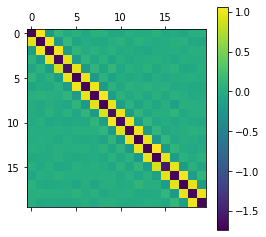

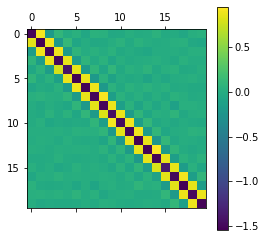

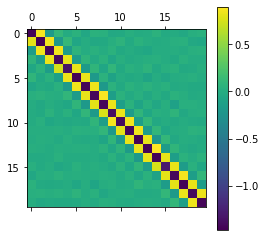

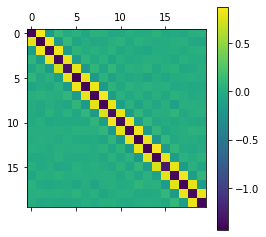

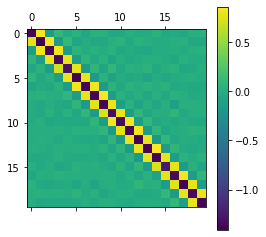

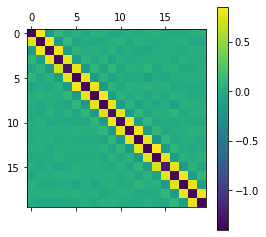

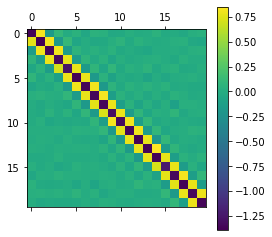

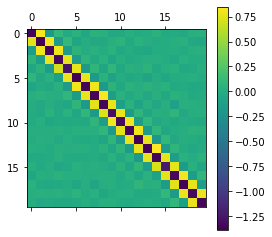

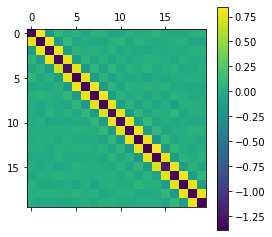

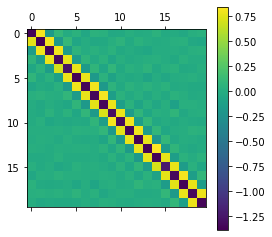

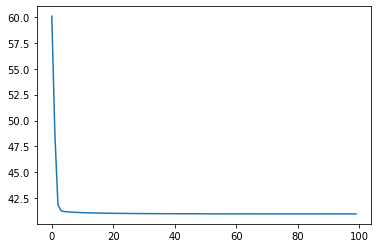

In [72]:
epochs = 100
batch_size = 100 
n_batches = int(I0.shape[0] / batch_size)
losses = []

I0, Ix = torch.tensor(I0), torch.tensor(Ix)

for ep in range(epochs):
    ep_loss = 0
    for i in range(n_batches):
        I0_batch, Ix_batch = I0[i*n_batches:(i+1)*n_batches,], Ix[i*n_batches:(i+1)*n_batches,]
        GI0, x, G = mod(I0_batch)
        
        loss, wmse = mod.loss(I0_batch, Ix_batch, GI0,  x, G)
        loss.backward()
        opt.step()
        opt.zero_grad()
        ep_loss += loss.item()
    
    losses.append(ep_loss)
    ep_loss = 0
    
    if (ep + 1) % 10 == 0:
        mod.show_G()
        
plt.plot(losses)
plt.show()
plt.close()

In [73]:
from scipy.linalg import logm
m = np.zeros((4,4))
for j in range(m.shape[1]):
    if j != m.shape[1] - 1:
        m[j + 1, j] = 1
    else:
        m[j,0] = 1
G_ana = logm(m)

logm result may be inaccurate, approximate err = 1.5461707496900602e+40
